In [ ]:
!pip install scipy
!pip install numpy<2

/bin/bash: line 1: 2: No such file or directory


In [ ]:
import random
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import scipy
from sklearn import datasets
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.cluster
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import MiniBatchKMeans
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from scipy.cluster.hierarchy import dendrogram

Part 0: Get The Data

In [ ]:
train = sklearn.datasets.fetch_20newsgroups(subset='train', remove=('headers', 'footers', 'quotes'),)
test = sklearn.datasets.fetch_20newsgroups(subset='test', remove=('headers', 'footers', 'quotes'),)
print('train data size:', len(train.data))
print('test data size:', len(test.data))

train data size: 11314
test data size: 7532


Part 1: Classic Features: BoW / TF-IDF Classification

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# imports for when we try the different classification models
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

In [ ]:
# loading the dataset, using all the categories and removing metadata (copied from Week 2 Lab Sample)
from sklearn.datasets import fetch_20newsgroups
data = fetch_20newsgroups(subset="all", remove=("headers","footers","quotes"), random_state = 42)

X_text = data.data[:10000]
y = data.target[:10000]
label_names = data.target_names

df = pd.DataFrame({"text": X_text, "label": y})


print("Dataset loaded.")
print("Rows:", len(df))
print("Labels:", label_names)
print("\nLabel distribution:")
print(df["label"].value_counts(normalize=True).rename("share"))

print("\nSample rows:")
df.head(3)

Dataset loaded.
Rows: 10000
Labels: ['alt.atheism', 'comp.graphics', 'comp.os.ms-windows.misc', 'comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos', 'rec.motorcycles', 'rec.sport.baseball', 'rec.sport.hockey', 'sci.crypt', 'sci.electronics', 'sci.med', 'sci.space', 'soc.religion.christian', 'talk.politics.guns', 'talk.politics.mideast', 'talk.politics.misc', 'talk.religion.misc']

Label distribution:
label
8     0.0562
5     0.0554
12    0.0551
15    0.0535
14    0.0525
10    0.0522
9     0.0521
3     0.0519
13    0.0516
4     0.0516
11    0.0515
6     0.0513
1     0.0513
2     0.0507
7     0.0495
17    0.0493
16    0.0485
0     0.0415
18    0.0399
19    0.0344
Name: share, dtype: float64

Sample rows:


,text,label
0,\n\nI am sure some bashers of Pens fans are pr...,10
1,My brother is in the market for a high-perform...,3
2,\n\n\n\n\tFinally you said what you dream abou...,17


In [ ]:
# Split into train+temp and test first
train_df, test_df = train_test_split(df, test_size=0.15, random_state=42, stratify=df['label'])

# split train_df into train and validation
train_df, val_df = train_test_split(train_df, test_size = 0.1765, random_state=42, stratify=train_df['label'])

print("Train:", len(train_df), "Val:", len(val_df), "Test:", len(test_df))

Train: 6999 Val: 1501 Test: 1500


In [ ]:
# checking for duplicates
def dup_rate(a, b):
    a_set = set(a["text"].astype(str))
    b_set = set(b["text"].astype(str))
    inter = a_set.intersection(b_set)
    return len(inter)

print("\nExact-duplicate counts across splits (should be ~0):")
print("Train ∩ Val:", dup_rate(train_df, val_df))
print("Train ∩ Test:", dup_rate(train_df, test_df))
print("Val   ∩ Test:", dup_rate(val_df, test_df))


Exact-duplicate counts across splits (should be ~0):
Train ∩ Val: 7
Train ∩ Test: 13
Val   ∩ Test: 4


## Bag of Words (BoW)

- with sklearn pipeline


In [ ]:
# BoW Pipeline

bow_models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "LinearSVM": LinearSVC(max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results_bow = {}

for name, model in bow_models.items():

    pipeline = Pipeline([
        ("vectorizer", CountVectorizer(
            max_features=20000,
            stop_words="english",
            min_df=2,
            ngram_range=(1,2)
        )),
        ("classifier", model)
    ])

    pipeline.fit(train_df["text"], train_df["label"])

    test_pred = pipeline.predict(test_df["text"])

    acc = accuracy_score(test_df["label"], test_pred)
    f1 = f1_score(test_df["label"], test_pred, average="macro")

    results_bow[name] = {
        "accuracy": acc,
        "macro_f1": f1,
        "model": pipeline,
        "predictions": test_pred
    }

    print(f"{name} — Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")


MultinomialNB — Accuracy: 0.6700 | Macro-F1: 0.6413
LogisticRegression — Accuracy: 0.6500 | Macro-F1: 0.6428
LinearSVM — Accuracy: 0.5933 | Macro-F1: 0.5858
RandomForest — Accuracy: 0.6300 | Macro-F1: 0.6126


In [ ]:
# Find best BoW model based on Macro-F1
best_bow_name = max(results_bow, key=lambda x: results_bow[x]["macro_f1"])
best_bow_info = results_bow[best_bow_name]

print("\nBest BoW Model:", best_bow_name)



Best BoW Model: LogisticRegression


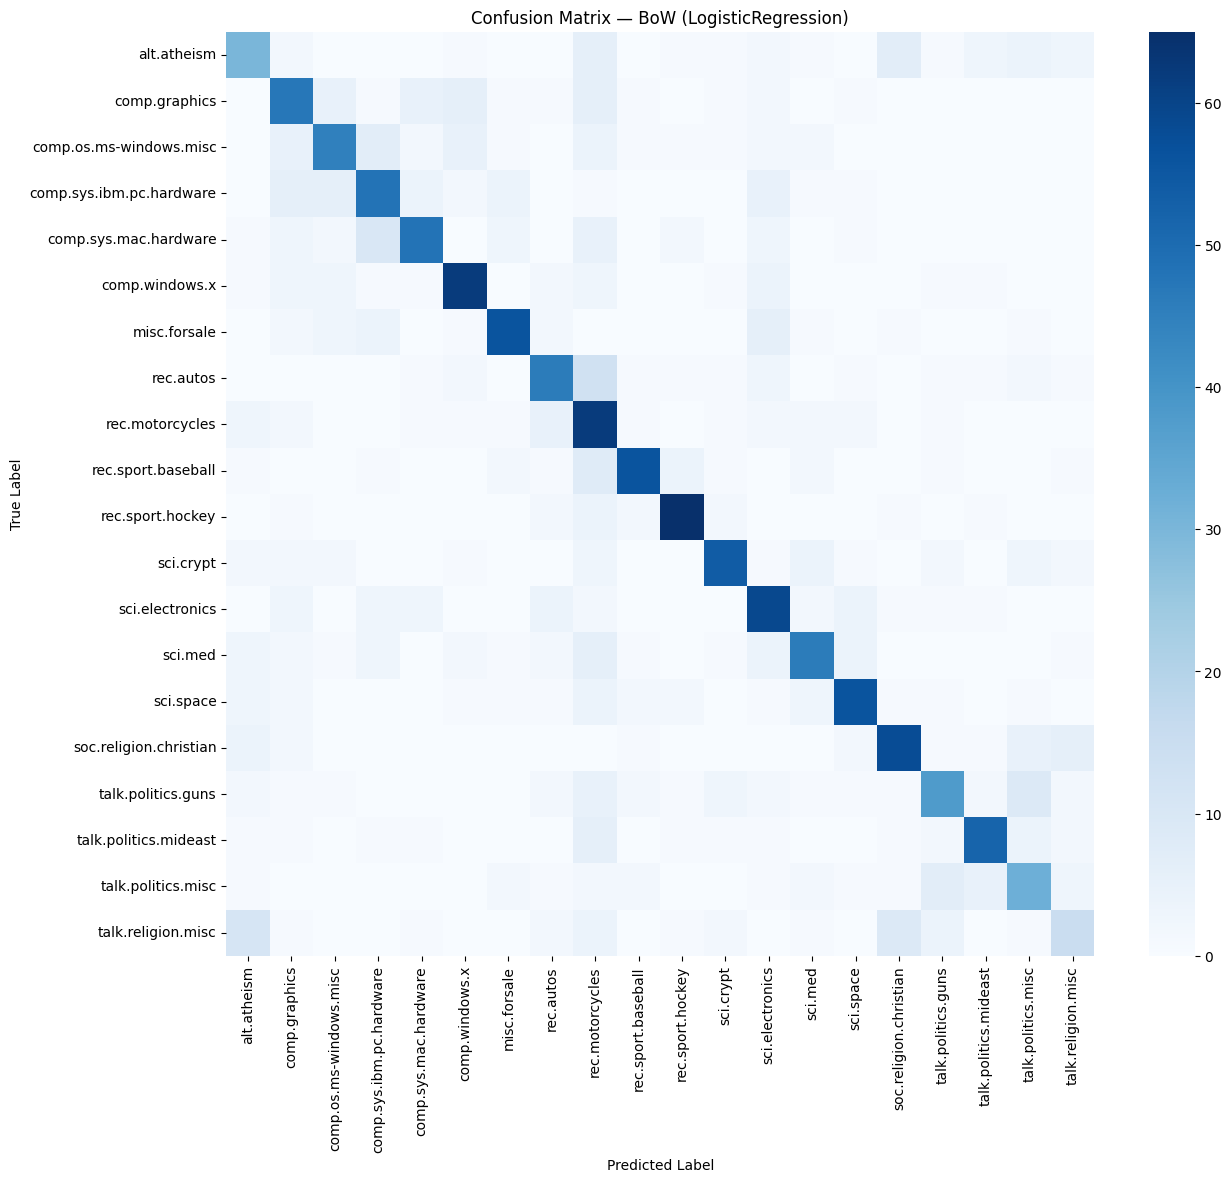

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm_bow = confusion_matrix(test_df["label"], best_bow_info["predictions"])

plt.figure(figsize=(14,12))
sns.heatmap(
    cm_bow,
    xticklabels=label_names,
    yticklabels=label_names,
    cmap="Blues"
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title(f"Confusion Matrix — BoW ({best_bow_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## Repeat for TF-IDF

In [ ]:
# TF-IDF Pipelines

tfidf_models = {
    "MultinomialNB": MultinomialNB(),
    "LogisticRegression": LogisticRegression(max_iter=2000),
    "LinearSVM": LinearSVC(max_iter=5000),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42)
}

results_tfidf = {}

for name, model in tfidf_models.items():

    pipeline = Pipeline([
        ("vectorizer", TfidfVectorizer(
            max_features=20000,
            stop_words="english",
            min_df=2,
            ngram_range=(1,2)
        )),
        ("classifier", model)
    ])

    pipeline.fit(train_df["text"], train_df["label"])

    test_pred = pipeline.predict(test_df["text"])

    acc = accuracy_score(test_df["label"], test_pred)
    f1 = f1_score(test_df["label"], test_pred, average="macro")

    results_tfidf[name] = {
        "accuracy": acc,
        "macro_f1": f1,
        "model": pipeline,          # store trained pipeline
        "predictions": test_pred    # store predictions
    }

    print(f"{name} — Accuracy: {acc:.4f} | Macro-F1: {f1:.4f}")


MultinomialNB — Accuracy: 0.6967 | Macro-F1: 0.6685
LogisticRegression — Accuracy: 0.7167 | Macro-F1: 0.6997
LinearSVM — Accuracy: 0.7220 | Macro-F1: 0.7135
RandomForest — Accuracy: 0.6520 | Macro-F1: 0.6338


In [ ]:
best_model_name = max(results_tfidf, key=lambda x: results_tfidf[x]["macro_f1"])
best_model_info = results_tfidf[best_model_name]

print("Best TF-IDF Model:", best_model_name)


Best TF-IDF Model: LinearSVM


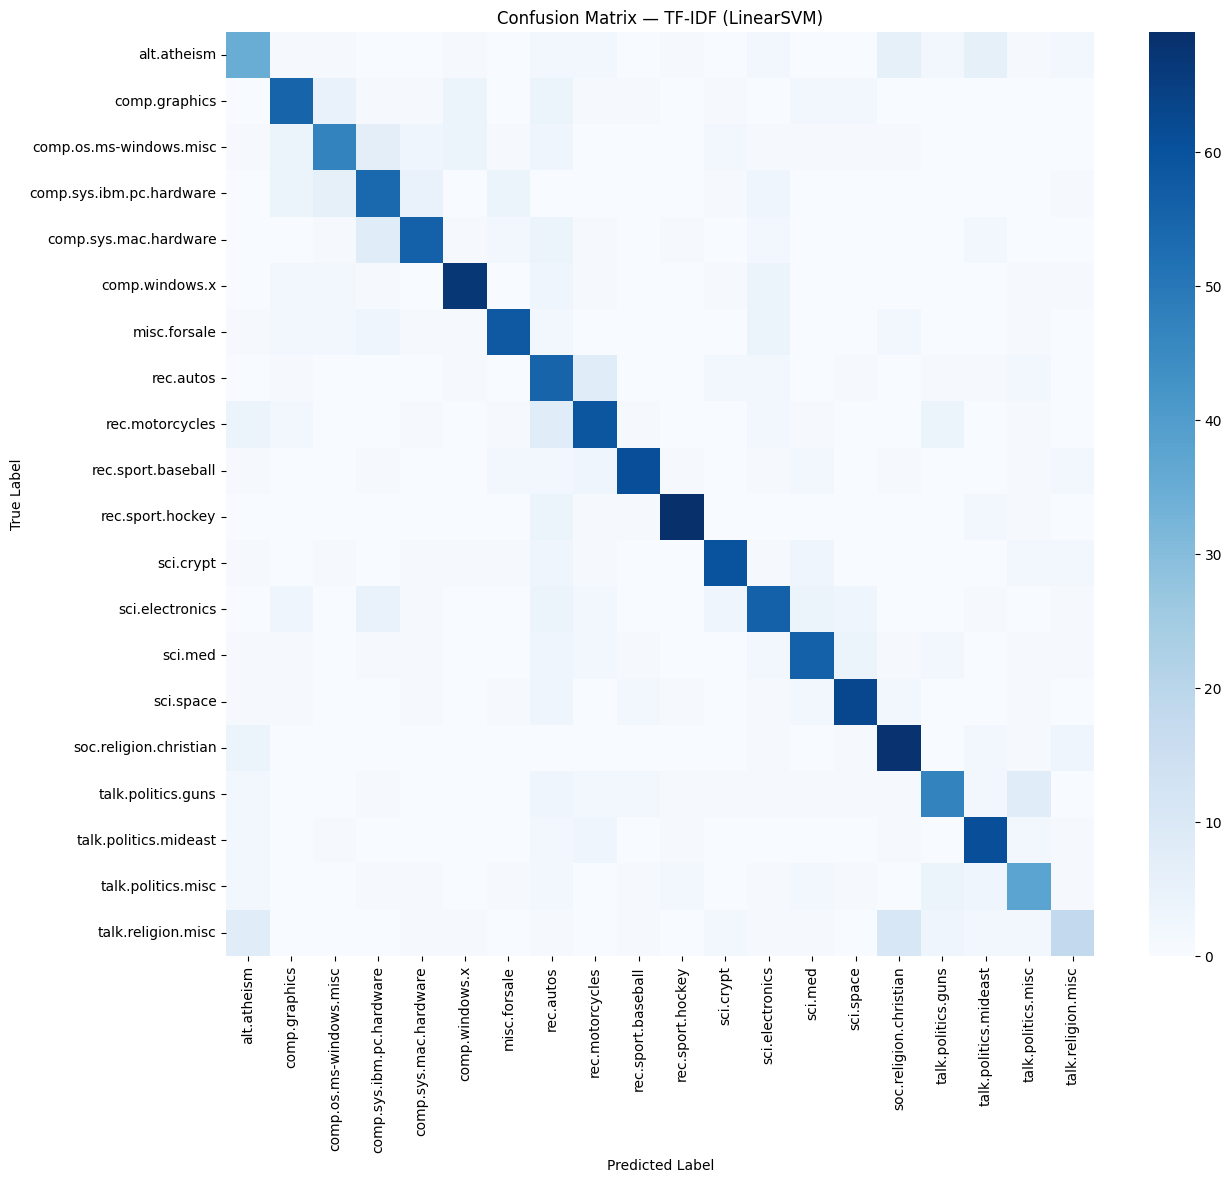

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(test_df["label"], best_model_info["predictions"])

plt.figure(figsize=(14,12))
sns.heatmap(
    cm,
    xticklabels=label_names,
    yticklabels=label_names,
    cmap="Blues"
)

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.title(f"Confusion Matrix — TF-IDF ({best_model_name})")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Part 2 - SentenceTransformer Embeddings + Classical Classifiers

In [ ]:
# Installing necessary package
!pip -q install sentence-transformers pypdf scikit-learn tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.6/330.6 kB 6.1 MB/s eta 0:00:00


In [ ]:
import os, re
import numpy as np
from tqdm import tqdm
from pypdf import PdfReader
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
MODEL_NAME = "sentence-transformers/all-MiniLM-L6-v2"
MAX_CHARS = 350
OVERLAP = 80
TOP_K = 10
BATCH_SIZE = 64

In [ ]:
def clean_text(s: str) -> str:
    s = s.replace("-\n", "")
    s = s.replace("\n", " ")
    s = re.sub(r"\s+", " ", s).strip()
    return s

def chunk_text(text: str,source_id: str,max_chars: int = 900,overlap: int = 120):
    """
    Returns list of chunk dicts
    """
    text = clean_text(text or "")
    if not text.strip():
        return []

    chunks = []
    start = 0
    k = 0
    while start < len(text):
        end = min(start + max_chars, len(text))
        chunk_text_ = text[start:end].strip()
        if chunk_text_:
            chunk_id = f"{source_id}::c{k}"
            chunks.append({
                "chunk_id": chunk_id,
                "source": source_id,
                "start": start,
                "text": chunk_text_,
            })
            k += 1
        if end == len(text):
            break
        start = max(0, end - overlap)

    return chunks

In [ ]:
def build_index(data_or_dir):
    all_chunks = []
    # --- Case A: sklearn Bunch (e.g., fetch_20newsgroups) ---
    if hasattr(data_or_dir, "data"):
        texts = data_or_dir.data
        targets = getattr(data_or_dir, "target", None)
        target_names = getattr(data_or_dir, "target_names", None)

        for i, doc in enumerate(texts):
            label = None
            if targets is not None and target_names is not None:
                label = target_names[targets[i]]

            source_id = f"20news::{label or 'doc'}::{i}"
            all_chunks.extend(chunk_text(doc, source_id, MAX_CHARS, OVERLAP))

    # --- Case B: list of raw strings ---
    elif isinstance(data_or_dir, list) and all(isinstance(x, str) for x in data_or_dir):
        for i, doc in enumerate(data_or_dir):
            source_id = f"text::{i}"
            all_chunks.extend(chunk_text(doc, source_id, MAX_CHARS, OVERLAP))

    else:
        raise TypeError(
            "build_index() expects a PDF directory path (str/pathlike), "
            "a sklearn Bunch with `.data`, or a list[str]."
        )

    if len(all_chunks) == 0:
        raise ValueError("No text extracted/chunked.")

    print(f"\nTotal chunks: {len(all_chunks)}")

    # --- Embeddings (same as your original) ---
    model = SentenceTransformer(MODEL_NAME)
    texts = [c["text"] for c in all_chunks]

    embs = []
    for i in tqdm(range(0, len(texts), BATCH_SIZE), desc="Embedding chunks"):
        batch = texts[i:i+BATCH_SIZE]
        emb = model.encode(batch, normalize_embeddings=True)
        embs.append(emb)

    embeddings = np.vstack(embs).astype(np.float32)
    return all_chunks, embeddings, model

In [ ]:
# Approach 1
# DO NOT RUN
# DO NOT RUN
# DO NOT RUN
datatrain = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"), random_state = 42)

chunks, embeddings, model = build_index(datatrain)

print("\nIndex ready. Try a query like:")
print('results = search("your query", chunks, embeddings, model, top_k=5)')


Total chunks: 51747


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Embedding chunks: 100%|██████████| 809/809 [43:14<00:00,  3.21s/it]


Index ready. Try a query like:
results = search("your query", chunks, embeddings, model, top_k=5)


In [ ]:
# Approach 2
# Load data
train = fetch_20newsgroups(subset="train", remove=("headers","footers","quotes"), random_state=42)
test  = fetch_20newsgroups(subset="test",  remove=("headers","footers","quotes"), random_state=42)

y_train, y_test = train.target, test.target
target_names = train.target_names

# Embed docs
st_model = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb = st_model.encode(train.data, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
X_test_emb  = st_model.encode(test.data,  batch_size=64, show_progress_bar=True, normalize_embeddings=True)

X_train_emb = np.asarray(X_train_emb, dtype=np.float32)
X_test_emb  = np.asarray(X_test_emb, dtype=np.float32)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Batches:   0%|          | 0/177 [00:00<?, ?it/s]

Batches:   0%|          | 0/118 [00:00<?, ?it/s]

In [ ]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix

def evaluate_model(name, clf, X_train, y_train, X_test, y_test, target_names=None):
    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)

    acc = accuracy_score(y_test, preds)
    f1m = f1_score(y_test, preds, average="macro")

    print(f"\n=== {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Macro F1: {f1m:.4f}")

    if target_names is not None:
        print("\nClassification report:")
        print(classification_report(y_test, preds, target_names=target_names))
    else:
        print("\nClassification report:")
        print(classification_report(y_test, preds))

    print("Confusion matrix shape:", confusion_matrix(y_test, preds).shape)
    return {"model": name, "accuracy": acc, "macro_f1": f1m}

results = []

# 1) MNB on dense embeddings (usually poor; also requires non-negative features)
# If you used normalize_embeddings=True, values can be negative -> MNB will error.
# Workaround: shift features to be non-negative (for completeness only).
X_train_mnb = X_train_emb - X_train_emb.min()
X_test_mnb  = X_test_emb  - X_train_emb.min()

results.append(evaluate_model("MultinomialNB (shifted embeddings)", MultinomialNB(),
                              X_train_mnb, y_train, X_test_mnb, y_test, target_names))

# 2) Logistic Regression
results.append(evaluate_model("Logistic Regression",
                              LogisticRegression(max_iter=2000, n_jobs=-1),
                              X_train_emb, y_train, X_test_emb, y_test, target_names))

# 3) Linear SVM
results.append(evaluate_model("Linear SVM (LinearSVC)",
                              LinearSVC(),
                              X_train_emb, y_train, X_test_emb, y_test, target_names))

# 4) Random Forest
results.append(evaluate_model("Random Forest",
                              RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
                              X_train_emb, y_train, X_test_emb, y_test, target_names))

results


=== MultinomialNB (shifted embeddings) ===
Accuracy: 0.6336
Macro F1: 0.5899

Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.46      0.04      0.07       319
           comp.graphics       0.66      0.69      0.68       389
 comp.os.ms-windows.misc       0.62      0.62      0.62       394
comp.sys.ibm.pc.hardware       0.51      0.65      0.57       392
   comp.sys.mac.hardware       0.72      0.43      0.54       385
          comp.windows.x       0.90      0.69      0.78       395
            misc.forsale       0.63      0.66      0.65       390
               rec.autos       0.52      0.78      0.63       396
         rec.motorcycles       0.63      0.70      0.66       398
      rec.sport.baseball       0.87      0.81      0.84       397
        rec.sport.hockey       0.94      0.86      0.90       399
               sci.crypt       0.70      0.68      0.69       396
         sci.electronics       0.46    

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



=== Logistic Regression ===
Accuracy: 0.6841
Macro F1: 0.6702

Classification report:
                          precision    recall  f1-score   support

             alt.atheism       0.48      0.47      0.47       319
           comp.graphics       0.66      0.70      0.68       389
 comp.os.ms-windows.misc       0.69      0.65      0.67       394
comp.sys.ibm.pc.hardware       0.61      0.61      0.61       392
   comp.sys.mac.hardware       0.67      0.62      0.65       385
          comp.windows.x       0.86      0.75      0.80       395
            misc.forsale       0.72      0.71      0.71       390
               rec.autos       0.54      0.78      0.64       396
         rec.motorcycles       0.72      0.72      0.72       398
      rec.sport.baseball       0.88      0.82      0.85       397
        rec.sport.hockey       0.89      0.88      0.89       399
               sci.crypt       0.78      0.71      0.74       396
         sci.electronics       0.57      0.56      0.5

[{'model': 'MultinomialNB (shifted embeddings)',
  'accuracy': 0.633563462559745,
  'macro_f1': 0.5899052726873726},
 {'model': 'Logistic Regression',
  'accuracy': 0.6841476367498672,
  'macro_f1': 0.670223168124063},
 {'model': 'Linear SVM (LinearSVC)',
  'accuracy': 0.6695432819968136,
  'macro_f1': 0.6545737832582378},
 {'model': 'Random Forest',
  'accuracy': 0.6566648964418481,
  'macro_f1': 0.6289370954625403}]

Pt 1  
MultinomialNB — Accuracy: 0.6967 | Macro-F1: 0.6685  
LogisticRegression — Accuracy: 0.7167 | Macro-F1: 0.6997  
LinearSVM — Accuracy: 0.7220 | Macro-F1: 0.7135  
RandomForest — Accuracy: 0.6520 | Macro-F1: 0.6338  

Pt 2  
MultinomialNB — Accuracy: 0.6336 | Macro-F1: 0.5899  
LogisticRegression — Accuracy: 0.6841 | Macro-F1: 0.6702  
LinearSVM — Accuracy: 0.6695 | Macro-F1: 0.6546  
RandomForest — Accuracy: 0.6567 | Macro-F1: 0.6546  

Across the board, part 1 has better performance over all models. This may be due to the nature of the original data - specific keywords matter a lot in preserving meaning, and TF-IDF preserves these word signals much better than semantic embeddings. Embeddings usually perform better in instances where paraphrasing and synonyms are important - however, on larger datasets with many distinctive words and unique vocabulary sets per topic, TF-IDF oftens wins.

Part 3-A: Top Level Clustering

In [ ]:
!pip install sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer

In [ ]:
#be careful when u run this cell. Took me 14 mins to execute.
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings = model.encode(train.data)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [ ]:
def purity_score(c, y):
  A = np.c_[(c,y)]
  n_accurate = 0.
  for j in np.unique(A[:,0]):
    z = A[A[:,0] == j, 1]
    x = np.argmax(np.bincount(z))
    n_accurate += len(z[z == x])
  return n_accurate / A.shape[0]

k= 1 done, purity: 0.0530316422131872
k= 2 done, purity: 0.10173236697896411
k= 3 done, purity: 0.14893052854870073
k= 4 done, purity: 0.15016793353367508
k= 5 done, purity: 0.19100229803782923
k= 6 done, purity: 0.2267102704613753
k= 7 done, purity: 0.2709033056390313
k= 8 done, purity: 0.30228036061516705
k= 9 done, purity: 0.3381651051794237
k= 10 done, purity: 0.3808555771610394


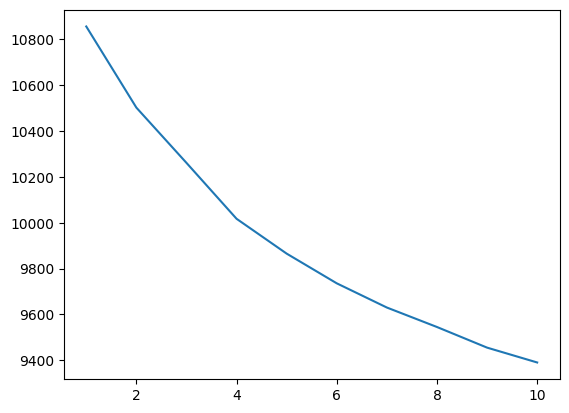

In [ ]:
import nltk

purity = []
wcss=[]

krange = range(1,11)
for k in krange:
  tclusterer = KMeans(n_clusters=k, init='k-means++', max_iter=500, n_init=5, algorithm="lloyd")
  clusts = tclusterer.fit_predict(embeddings)
  purity.append(purity_score(clusts, train.target))
  wcss.append(tclusterer.inertia_)
  print('k=',k,'done, purity:', purity[k-1])

plt.plot(krange, wcss)

Do not see a clear "elbow" so select k=9.

(array([1521., 1014., 1437., 2538.,    0., 1355., 1124., 1471.,  303.,
         551.]),
 array([0. , 0.8, 1.6, 2.4, 3.2, 4. , 4.8, 5.6, 6.4, 7.2, 8. ]),
 <BarContainer object of 10 artists>)

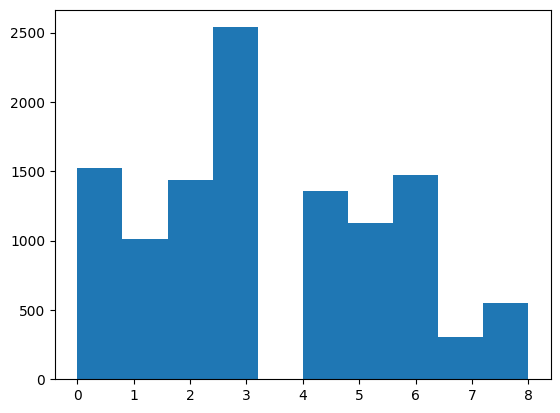

In [ ]:
random.seed(a = 200)

clusterer = KMeans(n_clusters=9, init='k-means++', max_iter=100, n_init=10)
clusts = clusterer.fit_predict(embeddings)
plt.hist(clusts)

In [ ]:
def cluster_purity(c, y):
  numy = len(set(y))
  cvals = list(set(c)) #[str(ce) for ce in list(set(c))]
  numc = len(cvals)
  ind = [str(cval) for cval in cvals] #np.arange(numc)
  bottom = np.zeros(numc)
  for yidx in range(numy):
    counts = np.zeros(numc)
    for cidx in range(numc):
      num = len(list(filter(lambda p: p[0]==cvals[cidx] and p[1]==yidx, zip(c,y))))
      counts[cidx] = num
    plt.bar(ind, counts,label=train.target_names[yidx],bottom=bottom)
    bottom = bottom + counts
  plt.legend()

Purity: 0.3402863708679512


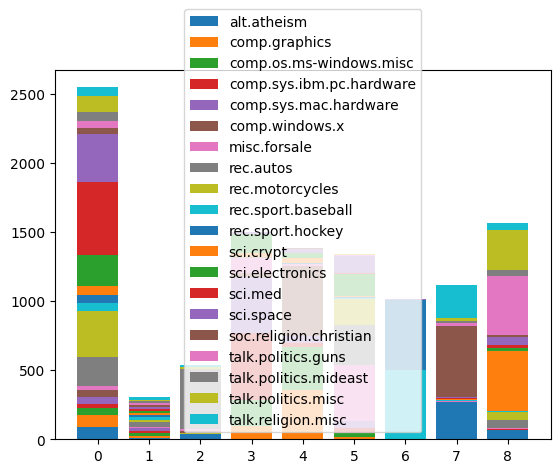

In [ ]:
cluster_purity(clusts, train.target)
print('Purity:', purity_score(clusts, train.target))

Find documents closest to the cluster centroid.

In [ ]:
from sklearn.metrics.pairwise import cosine_distances

In [ ]:
centroids = clusterer.cluster_centers_

In [ ]:
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute', metric='cosine').fit(embeddings)
distance, indices = nbrs.kneighbors(centroids)

In [ ]:
labels = clusterer.labels_
centroids = clusterer.cluster_centers_
closest_docs = {}

for cluster_id in range(9):
    # Get indices of documents in this cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Get embeddings for this cluster
    cluster_embeddings = embeddings[cluster_indices]

    # Compute cosine distance to centroid
    distances = cosine_distances(
        cluster_embeddings,
        centroids[cluster_id].reshape(1, -1)
    ).flatten()

    # Find closest document index
    closest_idx = cluster_indices[np.argmin(distances)]

    closest_docs[cluster_id] = train.data[closest_idx]

    print(f"\nCluster {cluster_id} representative document: {closest_idx}")
    print(f" -> {train.data[closest_idx]}")


Cluster 0 representative document: 6998
 -> No, not another false alarm, not a "It'll certainly be done by *next* week"
message...  No, this is the real thing.  I repeat, this is *not* a drill!

Batten down the hatches, hide the women, and lock up the cows, XV 3.00 has
finally escaped.  I was cleaning its cage this morning when it overpowered
me, broke down the office door, and fled the lab.  It was last seen heading
in the general direction of export.lcs.mit.edu at nearly 30k per second...

If found, it answers to the name of 'contrib/xv-3.00.tar.Z'.

Have a blast.  I'm off to the vacation capital of the U.S.:  Waco, Texas.

Cluster 1 representative document: 1089
 -> 






Cluster 2 representative document: 1577
 -> 


	Hate to be simple minded about this Tim, but I think its
really very simple.  He was a dirty Jew.  And the only good Jew, in
some peoples mind, is a dead Jew.  Thats what 40 years of propaganda
that fails to discriminate between Jew and Zionist will do.  Thats
what 

Use an LLM to generate a topic label for the cluster based on representative documents.

In [ ]:
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
STOPWORDS = set(stopwords.words('english'))


def extract_label(text: str, max_words: int = 4, min_word_len: int = 2) -> str:
    """
    Extract a short label from text by taking the most frequent meaningful words.

    Args:
        text: Input text.
        max_words: Maximum number of words in the label.
        min_word_len: Minimum length for a word to be considered.

    Returns:
        A short label string.
    """
    if not text or not str(text).strip():
        return ""

    # Normalize: lowercase, keep letters and spaces
    cleaned = re.sub(r"[^a-zA-Z\s]", " ", str(text).lower())
    words = [w for w in cleaned.split() if len(w) >= min_word_len and w not in STOPWORDS]

    if not words:
        # Fallback: first few words of original (truncated)
        fallback = str(text).split()[:max_words]
        return " ".join(fallback) if fallback else ""

    # Count and take most frequent, then preserve order of first occurrence
    counts = Counter(words)
    ordered = sorted(counts.keys(), key=lambda w: (-counts[w], words.index(w)))
    return " ".join(ordered[:max_words]).title()


def generate_labels(data: dict, max_words: int = 4) -> dict:
    """
    Generate a label for each key based on its text value.

    Args:
        data: Dictionary mapping keys (e.g. numbers) to text values.
        max_words: Maximum words per label.

    Returns:
        Dictionary mapping same keys to generated labels.
    """
    return {key: extract_label(value, max_words=max_words) for key, value in data.items()}

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
labels = generate_labels(closest_docs)
print("Generated labels:")
for key, label in labels.items():
    print(f"  {key}: {label}")

Generated labels:
  0: Xv Another False Alarm
  1: 
  2: Arafat People Jew Adam
  3: Meg Internal Floppy Drive
  4: Graphics User Exponent Plot
  5: Need Sell Offer Within
  6: Al Year Nl League
  7: Convenient Addressing Back Must
  8: Us Announcement Big Dan


Part 3-B: Second-Level Clustering on 2 Biggest Clusters.

In [ ]:
#Identify 2 largest clusters.
unique_elements, counts = np.unique(clusts, return_counts=True)

print(f"Unique elements: {unique_elements}")
print(f"Counts: {counts}")

Unique elements: [0 1 2 3 4 5 6 7 8]
Counts: [2548  303  537 1501 1388 1343 1017 1115 1562]


In [ ]:
#Extract docs in largest clusters
cl0 = [item for item, val in zip(train.data, clusts) if val == 0]
cl8 = [item for item, val in zip(train.data, clusts) if val == 8]

In [ ]:
cl0_target = [item for item, val in zip(train.target, clusts) if val == 0]
cl8_target = [item for item, val in zip(train.target, clusts) if val == 8]

In [ ]:
#This cell took 6 mins to execute. Be careful.
model = SentenceTransformer("all-MiniLM-L6-v2")

embeddings_0 = model.encode(cl0)
embeddings_8 = model.encode(cl8)

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sub-clustering and labeling of cluster 0.

(array([ 887.,    0.,    0.,    0.,    0., 1178.,    0.,    0.,    0.,
         483.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

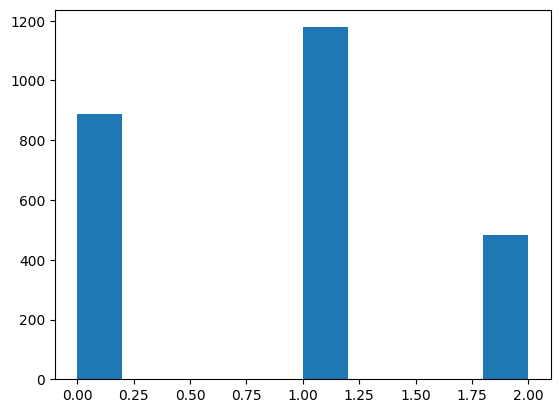

In [ ]:
random.seed(a = 200)

clusterer = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10)
clusts_0 = clusterer.fit_predict(embeddings_0)
plt.hist(clusts_0)

Purity: 0.3626373626373626


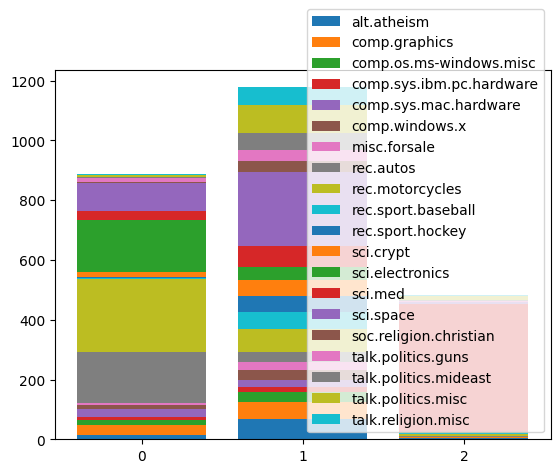

In [ ]:
cluster_purity(clusts_0, cl0_target)
print('Purity:', purity_score(clusts_0, cl0_target))

In [ ]:
centroids = clusterer.cluster_centers_
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute', metric='cosine').fit(embeddings_0)
distance, indices = nbrs.kneighbors(centroids)

labels = clusterer.labels_
centroids = clusterer.cluster_centers_
closest_docs_0 = {}

for cluster_id in range(3):
    # Get indices of documents in this cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Get embeddings for this cluster
    cluster_embeddings = embeddings_0[cluster_indices]

    # Compute cosine distance to centroid
    distances = cosine_distances(
        cluster_embeddings,
        centroids[cluster_id].reshape(1, -1)
    ).flatten()

    # Find closest document index
    closest_idx = cluster_indices[np.argmin(distances)]

    closest_docs_0[cluster_id] = cl0[closest_idx]

In [ ]:
labels = generate_labels(closest_docs_0)
print("Generated labels:")
for key, label in labels.items():
    print(f"  {key}: {label}")

Generated labels:
  0: Driveways Mph Live Quite
  1: Sci World Lack Extraneously
  2: People Msg Effects Read


Sub-clustering and labeling of cluster 8.

(array([354.,   0.,   0.,   0.,   0., 370.,   0.,   0.,   0., 838.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

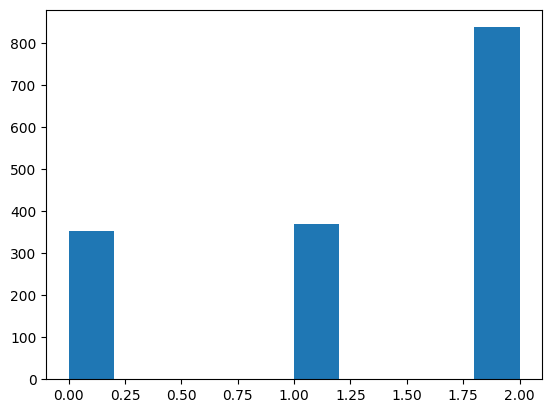

In [ ]:
random.seed(a = 200)

clusterer = KMeans(n_clusters=3, init='k-means++', max_iter=100, n_init=10)
clusts_8 = clusterer.fit_predict(embeddings_8)
plt.hist(clusts_8)

Purity: 0.5691421254801536


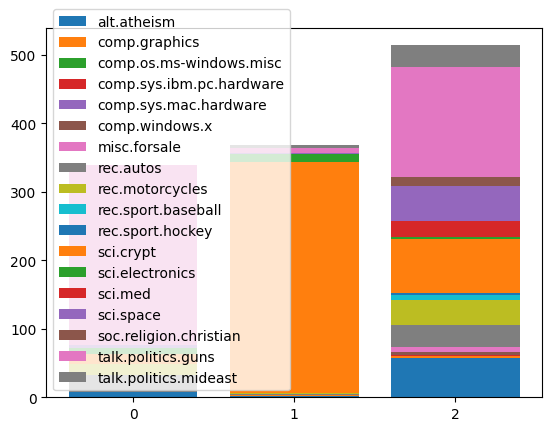

In [ ]:
cluster_purity(clusts_8, cl8_target)
print('Purity:', purity_score(clusts_8, cl8_target))

In [ ]:
centroids = clusterer.cluster_centers_
nbrs = NearestNeighbors(n_neighbors=11, algorithm='brute', metric='cosine').fit(embeddings_8)
distance, indices = nbrs.kneighbors(centroids)

labels = clusterer.labels_
centroids = clusterer.cluster_centers_
closest_docs_8 = {}

for cluster_id in range(3):
    # Get indices of documents in this cluster
    cluster_indices = np.where(labels == cluster_id)[0]

    # Get embeddings for this cluster
    cluster_embeddings = embeddings_8[cluster_indices]

    # Compute cosine distance to centroid
    distances = cosine_distances(
        cluster_embeddings,
        centroids[cluster_id].reshape(1, -1)
    ).flatten()

    # Find closest document index
    closest_idx = cluster_indices[np.argmin(distances)]

    closest_docs_8[cluster_id] = cl8[closest_idx]

In [ ]:
labels = generate_labels(closest_docs_8)
print("Generated labels:")
for key, label in labels.items():
    print(f"  {key}: {label}")

Generated labels:
  0: Guns Gun Crime Study
  1: Would Government Found Clipper
  2: Public Become Clinton Text


Part 3-C: Show the “Partial Tree"

In [ ]:
import scipy.cluster.hierarchy as sch

In [ ]:
num_points = 500
data = train.data[:num_points]
target= train.target[:num_points]
features = TfidfVectorizer(ngram_range=(1,2), stop_words= 'english', lowercase=True, max_features=300)
vecs = features.fit_transform(data)

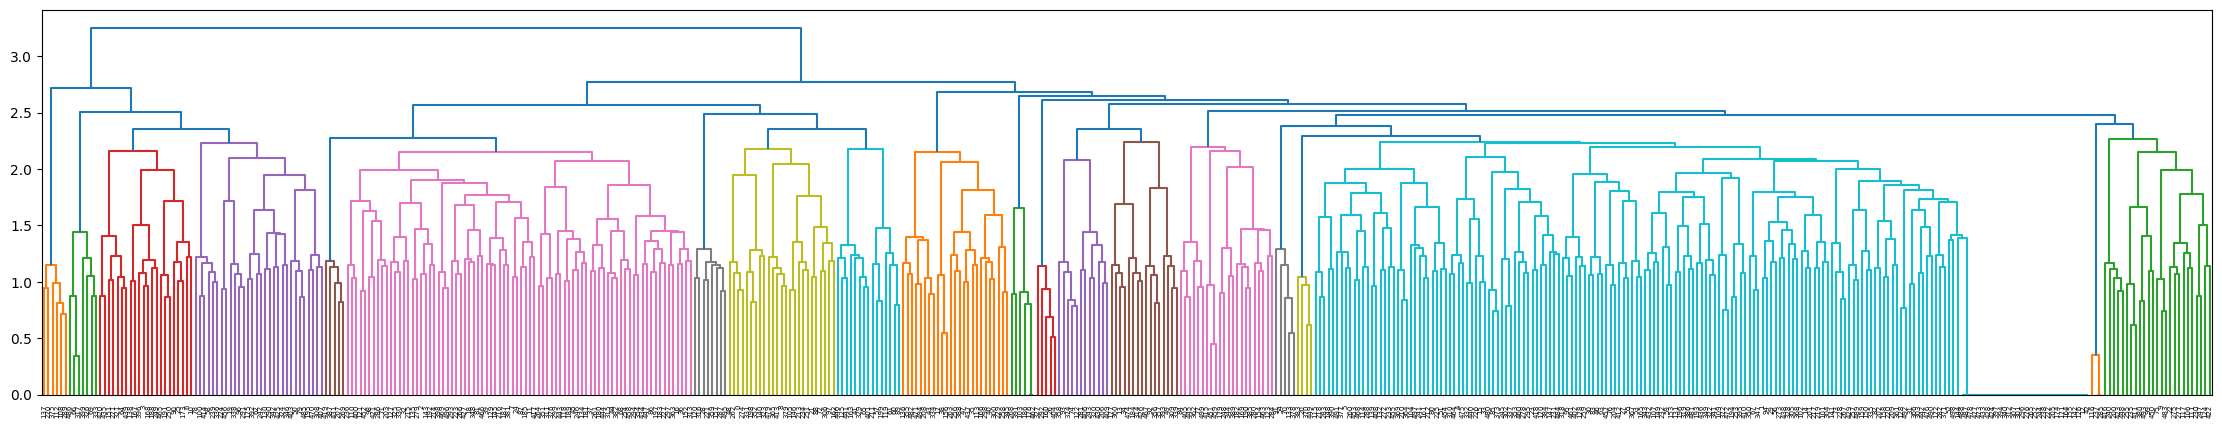

In [ ]:
plt.figure(figsize=(28,5))
dend = sch.dendrogram(sch.linkage(vecs.toarray(), method='ward'))
plt.show()